## 学习和使用回归分析

* 复习教材第8、9章内容，调试运行相关代码。
* 查阅scikit-learn工具包中回归学习器的相关说明，了解相关函数使用方法。
* 对波士顿房价数据集进行回归分析。

# 回归分析

## 线性回归

目标：给定数据集$D=\{(\boldsymbol{x_1},y_1),(\boldsymbol{x_2},y_2),...,(\boldsymbol{x_m},y_m)\}$ ，其中$\boldsymbol{x_i}=(x_{i1};x_{i2};...x_{id}), \ y_i \in R$，学习一个线性模型以尽可能准确地预测实值输出标记，即学习得到$f(x_i)\approx y_i$

先考虑简单的一元线性回归，目标是求得回归方程 $f(x)=wx_i+b$ 使得 $f(x_i)\approx y_i$ 。 $w$ 称为回归系数，求回归系数的过程就是回归。

我们可以简单地从一定量数据中求得回归方程。假定输入数据存放在矩阵 $\boldsymbol{X}$ 中，回归系数存放在向量 $w$ 中，对于给定的 $X_1$ ，预测结果将会通过 $Y_1 = X_1^T w$ 给出，通过计算预测Y和真实Y之间的差值，选择一个使得误差最小的 $w$ 。比如可以采用平方误差：

$$ \sum\limits_{i=1}^m (y_i - x_i^Tw)^2 $$

用矩阵表示则是 $ (y-\boldsymbol{X}w)^T(y-\boldsymbol{X}w $ 。对 $w$ 求导并令其为零，可以解出最优解（普通最小二乘法，OLS）

$$ \hat{w} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^Ty $$

计算过程中存在求逆运算，所以需要判断逆矩阵是否存在。

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) - 1 #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

def standRegres(xArr,yArr):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0.0: # 检查行列式是否为0
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*yMat) #.I 为逆运算
    return ws

In [13]:
xArr,yArr=loadDataSet('./data/ex0.txt')
display(xArr[0:2]) # X0,X1
display(yArr[0:2])

[[1.0, 0.067732], [1.0, 0.42781]]

[3.176513, 3.816464]

In [12]:
ws = standRegres(xArr,yArr)
ws

matrix([[3.00774324],
        [1.69532264]])

得到了回归系数，得到回归方程。y = ws[0] + ws[1] \* X1，可以绘图查看拟合效果

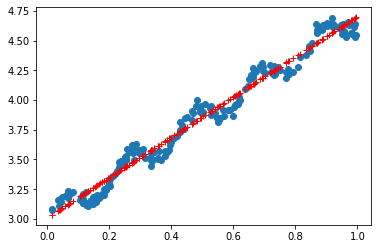

In [19]:
xMat = np.mat(xArr)
yMat = np.mat(yArr)
yHat = xMat*ws

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0])
xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy*ws
ax.plot(xCopy[:,1],yHat,'r+')

除了可视化，也可以使用计算相关系数的方法来评估回归效果。`numpy`自带的`corrcoef()`方法可以计算预测值和真实值的相关性：

In [21]:
np.corrcoef((xMat*ws).T, yMat)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

## 局部加权线性回归LWLR

一般的线性回归容易出现欠拟合，无法发现数据中的一些潜在模式。

局部加权线性回归给待预测点附近的每个点赋予一定的权重，在子集上基于最小均方差进行普通回归（每次回归都需要事先选取出对应的数据子集）。该算法解出的回归系数最优解为：

$$ \hat{w} = (\boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{W}y $$

其中 $\boldsymbol{W}$ 为一个矩阵，为每个数据点赋予权重。

LWLR使用“核”对附近的点赋予更高的权重。最常用的核为高斯核：

$$ w(i,i) = \exp{\left(-\dfrac{(x^{(i)}-x)^2}{2k^2}\right)} $$

In [24]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]     #Xi - X
        weights[j,j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

def lwlrTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

In [26]:
display(lwlr(xArr[0],xArr,yArr,1.0)) # 单点估计
display(lwlr(xArr[0],xArr,yArr,0.001)) # 单点估计

matrix([[3.12204471]])

matrix([[3.20175729]])

In [28]:
%%time
yHat = lwlrTest(xArr, xArr, yArr, 0.003) # 整体估计

CPU times: user 3.04 s, sys: 1.28 s, total: 4.32 s
Wall time: 2.2 s


局部加权线性回归增加了计算量，对每个点做预测时都必须使用整个数据集。

In [30]:
srtInd = xMat[:,1].argsort(0)
xSort = xMat[srtInd][:,0,:]

In [33]:
yHat1 = lwlrTest(xArr, xArr, yArr, 1)
yHat2 = lwlrTest(xArr, xArr, yArr, 0.01)
yHat3 = lwlrTest(xArr, xArr, yArr, 0.003)

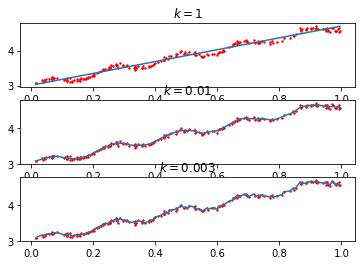

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.set_title('$k=1$')
ax1.plot(xSort[:,1],yHat1[srtInd])
ax1.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0], s=2, c='r')
ax2 = fig.add_subplot(312)
ax2.set_title('$k=0.01$')
ax2.plot(xSort[:,1],yHat2[srtInd])
ax2.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0], s=2, c='r')
ax3 = fig.add_subplot(313)
ax3.set_title('$k=0.003$')
ax3.plot(xSort[:,1],yHat3[srtInd])
ax3.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0], s=2, c='r')

可以观察到k取三种值时回归曲线的拟合情况。k过大可能导致欠拟合，k过小可能导致过拟合。